# Student Academic Performance Analysis

This notebook explores student demographics and exam scores to identify factors that influence performance. Features include pandas-based EDA, SQL insights, statistical tests, and regression modeling, plus summary findings and recommendations.

In [1]:
# Install these if needed:
# !pip install pandas matplotlib seaborn scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from scipy.stats import ttest_ind, f_oneway
from sklearn.linear_model import LinearRegression

## 1. Load Data

In [2]:
# Paste your CSV file name here
# Make sure the CSV file is in the same directory as this script


df = pd.read_csv("StudentsPerformance.csv") 

df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


## 2. Feature Engineering

In [3]:
# Add total and average score columns
df['total_score'] = df[['math score', 'reading score', 'writing score']].sum(axis=1)
df['average_score'] = df[['math score', 'reading score', 'writing score']].mean(axis=1)

# Encode categoricals for modeling/statistics
cat_cols = ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course']
for col in cat_cols:
    df[col + '_cat'] = df[col].astype('category').cat.codes

df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,total_score,average_score,gender_cat,race/ethnicity_cat,parental level of education_cat,lunch_cat,test preparation course_cat
0,female,group B,bachelor's degree,standard,none,72,72,74,218,72.666667,0,1,1,1,1
1,female,group C,some college,standard,completed,69,90,88,247,82.333333,0,2,4,1,0
2,female,group B,master's degree,standard,none,90,95,93,278,92.666667,0,1,3,1,1
3,male,group A,associate's degree,free/reduced,none,47,57,44,148,49.333333,1,0,0,0,1
4,male,group C,some college,standard,none,76,78,75,229,76.333333,1,2,4,1,1


## 3. Exploratory Data Analysis

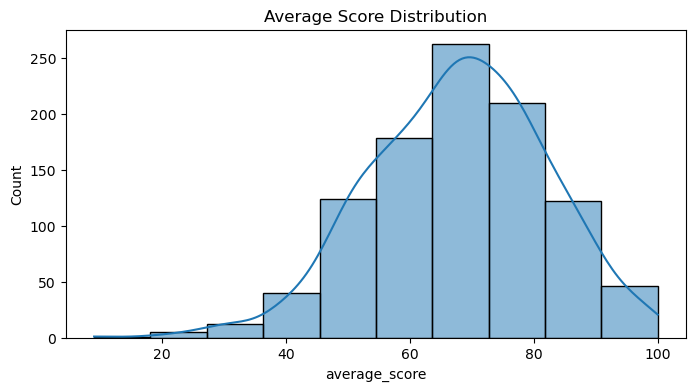

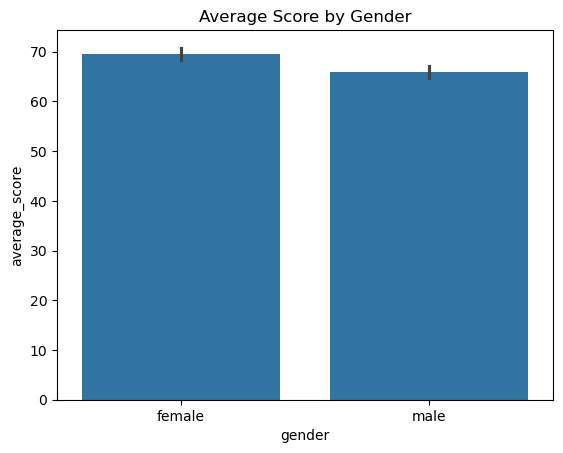

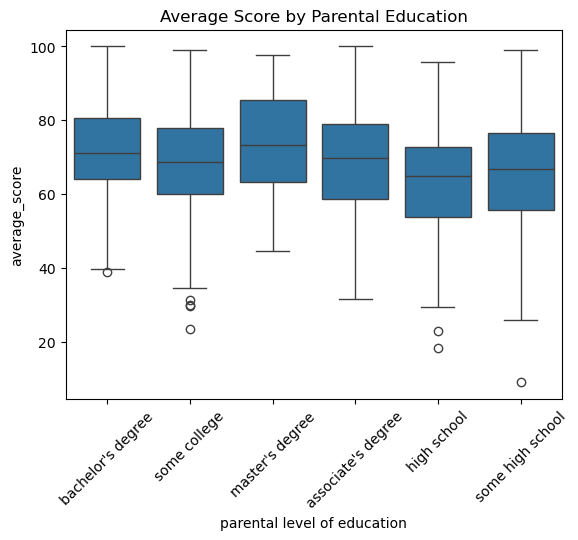

In [4]:
plt.figure(figsize=(8,4))
sns.histplot(df['average_score'], bins=10, kde=True)
plt.title('Average Score Distribution')
plt.show()

sns.barplot(x='gender', y='average_score', data=df)
plt.title('Average Score by Gender')
plt.show()

sns.boxplot(x='parental level of education', y='average_score', data=df)
plt.xticks(rotation=45)
plt.title('Average Score by Parental Education')
plt.show()

## 4. SQL Analysis (SQLite in-memory)

In [5]:
conn = sqlite3.connect(':memory:')
df.to_sql('students', conn, index=False, if_exists='replace')

# Grade category by average score
query_grade = '''
SELECT
  CASE
    WHEN average_score >= 85 THEN 'A'
    WHEN average_score >= 70 THEN 'B'
    ELSE 'C'
   END AS grade_category,
  COUNT(*) AS student_count
FROM students
GROUP BY grade_category
'''
display(pd.read_sql(query_grade, conn))

# Top 3 students by total score
query_top = '''
SELECT gender, `parental level of education`, `math score`, `reading score`, `writing score`, total_score
FROM students
ORDER BY total_score DESC
LIMIT 3
'''
display(pd.read_sql(query_top, conn))

,grade_category,student_count
0,A,116
1,B,343
2,C,541


,gender,parental level of education,math score,reading score,writing score,total_score
0,female,bachelor's degree,100,100,100,300
1,male,bachelor's degree,100,100,100,300
2,female,associate's degree,100,100,100,300


## 5. Statistical and Predictive Analysis

In [6]:
# T-test: Gender and math score
male_math = df[df['gender']=='male']['math score']
female_math = df[df['gender']=='female']['math score']
t_stat, p_val = ttest_ind(male_math, female_math)
print(f"T-test (gender & math score): t={t_stat:.2f}, p={p_val:.3f}")

# Regression: Predict math score
features = ['reading score', 'writing score', 'gender_cat', 'race/ethnicity_cat',
            'parental level of education_cat', 'lunch_cat', 'test preparation course_cat']
X = df[features]
y = df['math score']
model = LinearRegression().fit(X, y)
print('Regression R^2:', model.score(X, y))
print("Coefficients:", list(zip(features, model.coef_)))

T-test (gender & math score): t=5.38, p=0.000
Regression R^2: 0.8669058811736318
Coefficients: [('reading score', 0.3349686702822943), ('writing score', 0.615920303649363), ('gender_cat', 13.072133814877272), ('race/ethnicity_cat', 0.8485032448837266), ('parental level of education_cat', 0.08246633264948808), ('lunch_cat', 3.522551972349547), ('test preparation course_cat', 3.0195955264667247)]


## 6. Key Findings & Recommendations

| Key Insight                            | Recommendation                                   |
|-----------------------------------------|--------------------------------------------------|
| Females and prep course completers excel| Expand test-prep for all students                |
| Free/reduced lunch linked to low scores | Focused support for these students               |
| College-educated parents = stronger scores| Launch mentorship for lower-education families  |